## Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
from time import time

In [3]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [4]:
from fastai.learner import *
from fastai.column_data import *
from fastai.structured import *

In [5]:
path = './data/'

In [31]:
data = pd.read_csv(f'{path}simple_model_train.csv')

In [34]:
test = pd.read_csv(f'{path}simple_model_test.csv')

In [8]:
data.head(1)

,date_block_num,shop_id,item_id,item_category_id,Year,item_cnt_day,emon,etue,ewed,ethu,efri,esat,esun,ewday
0,0,0,32,40,2013,6.0,True,False,False,False,True,True,True,3


In [9]:
test.head(1)

,ID,shop_id,item_id,item_category_id,date_block_num,Year,emon,etue,ewed,ethu,efri,esat,esun,ewday
0,0,5,5037,19,34,2015,True,False,False,False,False,False,True,1


In [35]:
joined = pd.concat([data, test])

In [36]:
joined.reset_index(inplace=True, drop=True)

## Helpers

## Data Preparation

In [37]:
data.head(1)

,date_block_num,shop_id,item_id,item_category_id,Year,item_cnt_day,emon,etue,ewed,ethu,efri,esat,esun,ewday,last_month_cnt,last_month_val_null
0,0,0,32,40,2013,6.0,True,False,False,False,True,True,True,3,0.0,True


In [38]:
cat_cols = ['shop_id', 'item_id', 'item_category_id', 'Year', 'emon', 'etue', 'ewed', 'ethu', 'efri', 'esat', 'esun', 'last_month_val_null']
cont_cols = ['date_block_num', 'ewday', 'last_month_cnt']

In [39]:
for col in tqdm_notebook(cat_cols):
    joined[col] = joined[col].astype('category').cat.as_ordered()

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

In [40]:
for col in tqdm_notebook(cont_cols):
    joined[col] = joined[col].astype('float')

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

In [45]:
data = joined[joined.ID.isnull()]
test = joined[joined.ID.notnull()]

In [21]:
idxs = get_cv_idxs(len(data), val_pct=0.001)

In [46]:
idxs = list(data[data.date_block_num == 33].index)

In [47]:
data['cnt_clipped'] = data['item_cnt_day'].clip(0, 20)

/Users/vinodreddy/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [48]:
df, y, nas, mapper = proc_df(data, 'cnt_clipped', do_scale=True, skip_flds=['item_cnt_day', 'ID'])
# test_df, _, _, _ = proc_df(test, skip_flds=['ID', 'item_cnt_day'], do_scale=True, na_dict=nas, mapper=mapper)
model_data = ColumnarModelData.from_data_frame(path, idxs, df, y.astype(np.float32), cat_flds=cat_cols, bs=4096)

/Users/vinodreddy/Work/kaggle/competetive-data-science-final-project/fastai/structured.py:429: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df.drop(ignore_flds, axis=1, inplace=True)


In [49]:
cat_sz = [(c, len(data[c].cat.categories)+1) for c in cat_cols]
emb_szs = [(c, min(100, (c+1)//2)) for _,c in cat_sz]

## Build and Train

In [50]:
m = model_data.get_learner(emb_szs, len(df.columns)-len(cat_cols),
                   0.04, 1, [1000, 1000], [0.1,0.1])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 62%|██████▏   | 949/1541 [02:34<01:36,  6.14it/s, loss=8.14]

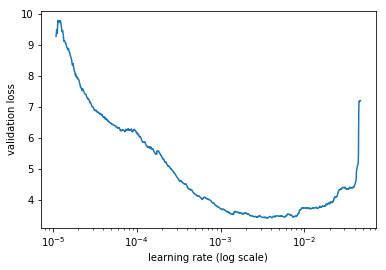

In [26]:
m.lr_find()
m.sched.plot()

In [51]:
m.fit(1e-3, 3, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      3.182302   4.63454   
    1      2.628787   4.57249                               
    2      2.348904   4.49838                               
    3      2.102676   4.599607                              
  9%|▉         | 35/386 [00:20<03:28,  1.68it/s, loss=2.1] 

KeyboardInterrupt: 

In [39]:
pred = m.predict(is_test=True)

In [45]:
pred = pred[:,0]

In [46]:
pred = np.clip(pred, 0, 20)

In [48]:
pred = np.round(pred)

In [49]:
pred_df = pd.DataFrame({'ID': test.ID, 'item_cnt_month': pred})

In [57]:
pred_df['ID'] = pred_df['ID'].astype(int)

In [58]:
pred_df.to_csv(f'{path}simple_model_submission_{int(time())}.csv', index=False, header=True)